## Learning from Kaggle Notebook

### Using tensorflow for image recognition

In [ ]:
pip install pydicom

In [ ]:
!pip install -q ../input/for-pydicom/pylibjpeg-1.4.0-py3-none-any.whl
!pip install -q ../input/for-pydicom/python_gdcm-3.0.14-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!pip install -q ../input/for-pydicom/pylibjpeg_libjpeg-1.3.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl

In [1]:
import os 
import pathlib
import glob 
from tqdm import tqdm 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pydicom
import tensorflow as tf

In [16]:
import boto3

s3 = boto3.resource('s3')
bucket_name = 'evan-callaghan-bucket'
bucket = s3.Bucket(bucket_name)

file_key = 'Kaggle-Spine-Fracture-Detection/train.csv'
file_key2 = 'Kaggle-Spine-Fracture-Detection/train_bounding_boxes.csv'

bucket_object = bucket.Object(file_key)
bucket_object2 = bucket.Object(file_key2)

file_object = bucket_object.get()
file_object2 = bucket_object2.get()

file_content_stream = file_object.get('Body')
file_content_stream2 = file_object2.get('Body')

## Reading the data
train = pd.read_csv(file_content_stream)
train_boxes = pd.read_csv(file_content_stream2)

In [2]:
sns.set()

## Defining parameters
EPOCHS = 10
BATCH_SIZE = 16
IMAGE_SIZE = (512, 512)
SEED = 42

## Setting seed
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
## Defining the study instance
study_instance = '1.2.826.0.1.3680043.5876'

## Listing all files in the folder
print(os.listdir('Sample_Images/'))

## Defining a list of all images
img_list = glob.glob('Sample_Images/*.dcm')

## Printing the length of the list
len(img_list)

['1.dcm', '4.dcm', '6.dcm', '2.dcm', '7.dcm', '3.dcm', '10.dcm', '8.dcm', '9.dcm', '5.dcm']


10

In [4]:
def load_dicom(path):
    """
    reads a dicom file and loads the image array inside it
    inputs:
        path - the path of the required dicom file
    returns:
        data - image pixel arrays
    """
    img = pydicom.dcmread(path)
    data = img.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data

In [5]:
def data_generator():
    """
    a function that will load the dataset from a list of image paths
    """
    for path in img_list:
        data = load_dicom(path)
        yield data  # return the data has generator

In [6]:
## Defining a tensorflow dataset variable that will use the generator to load the image data
train_dataset = tf.data.Dataset.from_generator(data_generator, (tf.uint8))

## Looking of the dataset contents
for i in train_dataset.take(1):
    print(i.shape)
    print(type(i))

2022-08-20 14:19:08.972282: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-08-20 14:19:08.972377: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-16-83-243.ca-central-1.compute.internal): /proc/driver/nvidia/version does not exist
2022-08-20 14:19:09.041587: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(512, 512)
<class 'tensorflow.python.framework.ops.EagerTensor'>


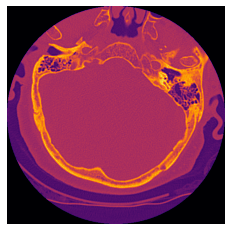

In [8]:
def show_single(img, cmap="inferno"):
    """
    plots a single image
    """
    plt.imshow(img, cmap=cmap)
    plt.axis("off")
    
show_single(i)

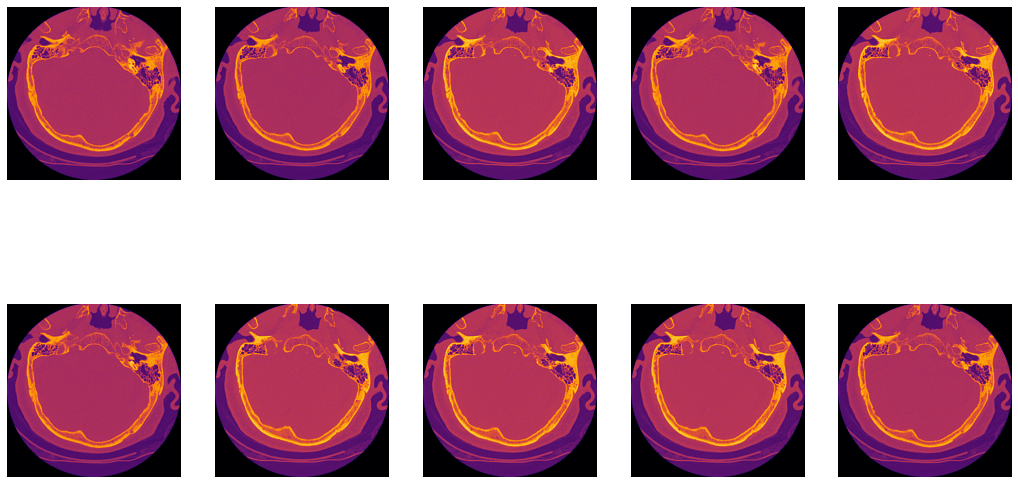

In [15]:
def show_batch(cmap="inferno"):
    """
    visualizes a batch of images
    """
    plt.figure(figsize=(18, 10))
    for i, img in enumerate(train_dataset.take(10)):  # iterate through the dataset
        plt.subplot(2, 5, i+1)
        show_single(img, cmap=cmap)
    plt.show()
    
show_batch()

In [ ]:
# lets modify the data generator, use 10 study instances
def data_generator():
    for i, study_instance in enumerate(train_df.StudyInstanceUID[:5]):
        for dcm in os.listdir(DATA_DIR + f"train_images/{study_instance}"):
            train_labels = []
            path = DATA_DIR + f"train_images/{study_instance}/{dcm}"
            
            img = load_dicom(path)
            
            # resize each image into a shape of (512, 512)
            img = np.resize(img, (512, 512))
            #  normalize image
            img = img / 255.0
            # convert from gray scale to rgb, this will be helpful incase we want to use pretrained models
            img = tf.expand_dims(img, axis=-1)
            img = tf.image.grayscale_to_rgb(img)
            
            train_labels.extend([
                train_df.loc[i, "C1"],
                train_df.loc[i, "C2"],
                train_df.loc[i, "C3"],
                train_df.loc[i, "C4"],
                train_df.loc[i, "C5"],
                train_df.loc[i, "C6"],
                train_df.loc[i, "C7"],
                train_df.loc[i, "patient_overall"] # end with patient overall
            ])
            yield img, train_labels

In [ ]:
## Defining the study instance
study_instance = '1.2.826.0.1.3680043.5876'